In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import sys
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
sys.path.append('/Users/ramtinyazdanian/PycharmProjects/job_skill_trend_analysis/')
from utilities.common_utils import *
from utilities.analysis_utils import *
from utilities.pandas_utils import *
from utilities.survey_response_utils import *
from utilities.classifier_utils import *
from utilities.constants import *
from utilities.params import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scipy.stats import shapiro, anderson, probplot
from scipy import stats

# Loading data

## Ad data

In [2]:
# Here, we will preprocess ad data, just like we had in the previous notebook.
root_data_path = '/Users/ramtinyazdanian/Downloads/jobtech/'
all_filenames = os.listdir(root_data_path)
all_dataframes = [pd.read_csv(os.path.join(root_data_path,filename)) 
                  for filename in all_filenames if filename[-3:] == 'csv' and filename[0] != '~']
df_all = pd.concat(all_dataframes)
df_all_useful_cols = df_all[['companyName', 'industryId', 'datePosted', 'skills']].rename(columns={
    'companyName': 'Company', 'industryId': 'Industry', 'datePosted': 'Date', 'skills': 'Skill List'
})

df_all_useful_cols['Skill List'] = df_all_useful_cols['Skill List'].apply(eval)
df_all_useful_cols['Date'] = pd.to_datetime(df_all_useful_cols['Date'])
company_totals = divide_into_periods(df_all_useful_cols, ['Company'], result_col_name='Total')

df_all_useful_cols = explode(df_all_useful_cols, ['Skill List'])
df_all_useful_cols = df_all_useful_cols.loc[df_all_useful_cols['Skill List'].apply(lambda x: x != '')]

df_all_useful_cols['Skill'] = df_all_useful_cols['Skill List'].apply(lambda x: x['skill'])
df_all_useful_cols['Skill Type'] = df_all_useful_cols['Skill List'].apply(lambda x: x['skillTypeId'])
df_all_useful_cols = df_all_useful_cols.drop(columns='Skill List')

In [3]:
absolute_start = np.datetime64('2017-01-01')
absolute_end = np.datetime64('2020-01-01')
it_skills = set(pd.read_csv('./it_skills.csv').Skill.values)
skills_df = divide_into_periods(df_all_useful_cols.loc[(df_all_useful_cols['Skill Type'] == 1) | 
                                                       (df_all_useful_cols['Skill Type'] == 2)], 
                                ['Company', 'Skill'], 
                                absolute_start, absolute_end, result_col_name='Job Postings Raw')
skills_df = pd.merge(skills_df, company_totals, on = ['Company', 'Date'])
skills_df['Job Postings'] = skills_df['Job Postings Raw'] / skills_df['Total']
skills_df = skills_df.loc[skills_df.Skill.apply(lambda x: x in it_skills)]

In [4]:
skills_df.sort_values('Date').head(10)

,Company,Skill,Date,Job Postings Raw,Total,Job Postings
124152,M1 Limited,python,2017-01-01,2,22,0.090909
100834,IHIS - Integrated Health Information Systems P...,ssl/tls,2017-01-01,1,15,0.066667
100833,IHIS - Integrated Health Information Systems P...,sql,2017-01-01,1,15,0.066667
15900,Agilysys Singapore Pte Ltd,system integration,2017-01-01,1,2,0.500000
15899,Agilysys Singapore Pte Ltd,sql,2017-01-01,1,2,0.500000
15895,Agilysys Singapore Pte Ltd,pos system,2017-01-01,1,2,0.500000
15894,Agilysys Singapore Pte Ltd,multi-task,2017-01-01,1,2,0.500000
15893,Agilysys Singapore Pte Ltd,microsoft office suite,2017-01-01,1,2,0.500000
15892,Agilysys Singapore Pte Ltd,microsoft office (powerpoint),2017-01-01,1,2,0.500000
15891,Agilysys Singapore Pte Ltd,microsoft office (excel),2017-01-01,1,2,0.500000


In [5]:
sorted(skills_df.Skill.unique().tolist())

['.net',
 '3d graphics',
 '3d modeling',
 'a/b testing',
 'ab initio',
 'account management',
 'accounting information systems',
 'aconex',
 'active directory',
 'active directory federation services (adfs)',
 'adas (architecture design and assessment system)',
 'admission & ticket management',
 'ado.net',
 'adobe acrobat pro',
 'adobe after effects',
 'adobe analytics',
 'adobe campaign',
 'adobe cq5',
 'adobe creative suite',
 'adobe dreamweaver',
 'adobe experience manager',
 'adobe flash',
 'adobe illustrator',
 'adobe indesign',
 'adobe lightroom',
 'adobe marketo',
 'adobe phonegap',
 'adobe photoshop',
 'adobe premiere pro',
 'adobe xd',
 'aecosim',
 'ahrefs (seo)',
 'airflow',
 'aix',
 'ajax',
 'algorithm design',
 'altera quartus',
 'amazon dynamodb',
 'amazon redshift',
 'amazon web services',
 'aml/cft',
 'amortization',
 'ampl',
 'amqp',
 'anaconda',
 'analytical design',
 'android',
 'android sdk',
 'android studio',
 'angularjs',
 'animation',
 'annuity',
 'anova',
 'ansi

## Survey data

In [6]:
survey_data_filename = \
    '/Users/ramtinyazdanian/Downloads/Emerging skills and trend-anticipating firms - SGE_October 16, 2020_03.57.csv'
survey_data = pd.read_csv(survey_data_filename)
survey_in_rows = get_responses_in_rows([survey_data], filter_nonsense=True, keep_unfinished=False)

Now let's see a histogram of the skills' number of non-Unsure responses. The ones with less than 3 non-Unsures should probably be filtered out, but let's keep them for now.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2a99b240>]],
      dtype=object)

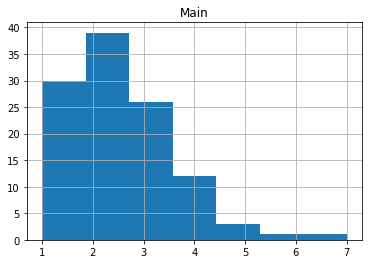

In [7]:
survey_in_rows[['Skills', 'Main']].loc[survey_in_rows['Main'] != UNSURE]\
    .groupby('Skills').count().sort_values('Main').hist(bins=7)

In [8]:
skills_to_keep = survey_in_rows[['Skills', 'Main']].loc[survey_in_rows['Main'] != UNSURE]\
    .groupby('Skills').count().reset_index()
skills_to_keep = skills_to_keep.loc[skills_to_keep['Main'] > 0].Skills.values
survey_in_rows = survey_in_rows.loc[survey_in_rows.Skills.apply(lambda x: x in skills_to_keep)]

## Auxiliary firm data

# Computing survey ground truth

The time period settings (and other settings) should be set through utilities/constants.py.

In [9]:
# Use assemble_question_responses (or get_responses_in_rows) followed by find_majority_response_ground_truth 
# on the skills.
majorities, ground_truth_for_periods = find_majority_response_ground_truth(survey_in_rows)

Let's see some of the ground truth emerging skills for 2017-2020.

In [10]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(majorities)

,Skills,Main,YesCol,NoCol,majority,modified_yescol,2017-2018,2018-2019,2019-2020,2018-2020,2017-2019,2017-2020
0,a/b testing,"[Unsure, Yes, Unsure]","[nan, Since 2017, nan]","[nan, nan, nan]",1,[2017-2020],True,False,False,False,True,True
1,adobe illustrator,"[Unsure, No, No]","[nan, nan, nan]","[nan, Skill has been important for too long, S...",0,[],False,False,False,False,False,False
2,ajax,"[No, Unsure, No]","[nan, nan, nan]","[nan, nan, Skill has been important for too long]",0,[],False,False,False,False,False,False
3,amazon redshift,"[Unsure, Yes, Unsure, Unsure, Unsure]","[nan, Since 2019, nan, nan, nan]","[nan, nan, nan, nan, nan]",1,[2019-2020],False,False,True,True,False,True
4,android studio,"[Yes, Yes, No]","[Since 2017, Earlier than 2017, nan]","[nan, nan, Skill has been important for too long]",1,[2017-2020],True,False,False,False,True,True
5,animation,"[No, Yes]","[nan, Earlier than 2017]","[Skill has been important for too long, nan]",0,[],False,False,False,False,False,False
6,ansible,"[Unsure, Yes, Unsure, Unsure]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",1,[],False,False,False,False,False,False
7,apache hive,"[Unsure, Unsure, Yes]","[nan, nan, Earlier than 2017]","[nan, nan, nan]",1,[],False,False,False,False,False,False
8,apache kafka,"[Yes, Yes, Unsure, Unsure, Unsure]","[Since 2017, Since 2017, nan, nan, nan]","[nan, nan, nan, nan, nan]",1,"[2017-2020, 2017-2020]",True,False,False,False,True,True
9,apache maven,"[No, Unsure, No, Yes, Unsure, Unsure, Unsure, ...","[nan, nan, nan, Earlier than 2017, nan, nan, n...","[Skill is not important enough, nan, Skill is ...",0,[],False,False,False,False,False,False


In [11]:
len(ground_truth_for_periods['2017-2020']), majorities.shape[0]

(41, 112)

In [12]:
ground_truth_for_periods['2017-2020']

['a/b testing',
 'amazon redshift',
 'android studio',
 'apache kafka',
 'augmented/virtual reality',
 'automation testing',
 'biostatistics',
 'blockchain technology',
 'computer vision',
 'cyber threat management',
 'data migration',
 'data quality control',
 'data science',
 'data security',
 'data visualisation',
 'docker',
 'elasticsearch',
 'encryption/cryptography',
 'fintech',
 'ggplot',
 'google analytics',
 'google go programming language',
 'graphql',
 'hadoop',
 'keras',
 'knowledge management',
 'market analysis',
 'micro-services',
 'mongodb',
 'nltk',
 'oauth 2.0',
 'plc programming',
 'quantitative analysis',
 'react.js',
 'search engine optimization (seo)',
 'sketch',
 'social media (youtube)',
 'spring framework',
 'tableau',
 'tensorflow',
 'vue.js']

### Looking at inter-rater agreement for the skills

We use Krippendorf's alpha.

In [13]:
# simply use get_interrater_agreement from survey_response_utils
get_interrater_agreement(survey_in_rows, remove_unsure=True)

0.2136900780379043

Okay this inter-rater agreement is just terrible. It shows that people don't seem to agree, and the results of the survey may not be particularly useful.

### Creating a train/validation/test split for the evaluation of the pop methods and weights

Doing a train/validation/test split here makes sense because we are essentially training each model (rawpop, logpop, binpop) on the training data (i.e. survey ground truth) by choosing the weights (through training) and thresholds (hyperparameters set using the validation set or CV) based on F1 on the training data. However, this is a strong assumption about the survey data: that they actually _are_ ground truth, and that training a model on part of them and testing it on another does conceptually make sense. This assumption is only valid if we have enough survey data to create a respectable train/validation/test split.

On the other hand, this is our only choice, because choosing the weights based on _all_ the survey data, and then presenting the F1 as our metric makes no sense, as it's basically just reporting the training error as the "error", which would have nothing to do with the model's ability to generalise. So we have the validation set (or CV) to find the best hyperparameters, then we train the weights on all the training data and use the test set to see the performance of the model on _data it has never seen in training_. This will let us see how well we can, in the best case, approximate the results of the survey. Just the usual stuff.

Now, the important question is how we create the split: do we split by person (i.e. each set is made up of the full responses of several people), by skill (i.e. each set is made up of the final ground truth for a set of skills), or by individual skill responses (i.e. some of the responses for a skill could be in one set and some in another). Among these three, only the second makes sense, as the first and third can lead to serious inconsistencies (e.g. a skill could be Yes in one set and No in the other). So **we split by skill**.

Another thing to remember is that the precision and recall only matter on the positive class and not on the negative class, as the negative class is sort of the "default" and much bigger than the positive class.

Finally, a critical question is our treatment of skills that _weren't in the survey_. Do we consider them to be negatives? If we do, we may be assuming too much, since some of them might have been emerging skills if we'd asked people about them. On the other hand, if we exclude them, then our set is limited to skills that were in the survey, which is a small set. However, a nice solution to this issue is to only count the TP and FN rate (true positive and false negative). This requires literally nothing but "which Yes skills did we get" and "which Yes skills did we miss". However, it disregards the number of skills that each method produces as its results, which is an important thing when comparing different thresholds (since more restrictive thresholds will naturally produce fewer "emerging skills" and they would obviously perform worse, even though their recall or precision may have been better). An alternative solution is to compute and present _all of these things_, meaning:
* TP and FN rates
* Precision, Recall, and F1 assuming Full-Unsures are "No"s and Out-of-survey skills don't exist.
* Precision, Recall, and F1 assuming Full-Unsure and Out-of-survey skills are "No"s.

Out of these three, the first two are more valid, since the assumption that all Out-of-surveys are "No"s may be too big. Since we're going to be training an _actual classifier model_ on the data, I think we're going to have to choose, and to me, what makes the most sense is to go with the second option, as using the third option will beg the question "what did you do all this survey stuff for then".

# Investigating the popularity profiles of several actual emerging skills

In [373]:
# Call investigate_skill_pop_profile(df, skill, pop_type, time_period, normaliser, smooth) 
# on several skills and plot the results.

# The decision regarding the types of features to be used in the computation of emerging skills is made here.

# Computing emerging skills and evaluating them

We have a train/validation/test split (or a train/test split if we want to do cross-validation), and now it's time to define what exactly our training process is like, and what the feature weights, objective, and hyperparameters are.

* Data points: Data points are as follows: Each skill-period pair constitutes one data point. What does this mean? It means that tensorflow_2017-2018 is one data point, and tensorflow_2017-2020 is another, et cetera. This means that we do not have to treat each time period as a separate entity and only deal with one dataset. If we didn't do this, we would have to train a separate model for each period, giving us 6 models with 6 weight vectors, and then we would have to average their F1-scores. The advantage of having one model is that we have more training data for the model, but the disadvantage is how much the "i.i.d." assumption is violated when we have 2017-2018 data _and_ 2017-2019 data _and_ 2017-2020 data etc. all as part of the input for _one_ model. Still, training data is very limited and I consider this combined model preferable.

* Features and output: The features are extracted for every single skill-period based on its pop profile (depending on the method chosen), yielding a n_skills * n_features matrix. The output variable for each data point is 1 if the skill has been considered emerging (by our respondents) in that time period, 0 if not. Full-Unsure skills should be considered "No"s in order not to limit the training set too much, but we may have to take them out of the set.

* Weights: The weights are the vector whose dot product with each skill-period's feature vector yields its **score**. The score is then subjected to the score lower bound, and the skill's rawpop is also checked against the rawpop upper bound.

* Other model parameters (not hyperparameters): The score lower bound can be considered to be another model parameter, which we would train alongside the weights (e.g. it could be integrated into the feature weights by adding a constant 1 feature, or it could be alternately optimised). The lower bound would not necessarily be a quantile, since we're optimising it anyway and the constraint that it be a specific quantile is unnecessary. The alternative is to treat the score lower bound as a hyperparameter, which I think is a bad idea.

* Hyperparameters: The score lower bound can be a hyperparameter. The rawpop upper bound is definitely a hyperparameter, since the quantity it thresholds is, unlike the score, predetermined and thus constant for each model and making it a hyperparameter immensely simplifies things (since it just makes a bunch of skills instant negatives).

* Train/test split: We have a training/test split on our data (6 splits if we have one model per period, and this is for each pop method). The training data can further be split into train/validation (or we could do cross-validation) to first find the best hyperparameters (per model) and then we would train the model on the entire training set using the best hyperparameters and look at its performance on the test set to see how well it manages to generalise to the hidden results of the survey. Based on the models' performance on the test set, we choose the _best model_ that we will use for the rest of the study (and at this point the model is already trained, I don't think we'd want to now retrain that model with its best hyperparameters on the entire dataset, since this kinda defeats the purpose of a train/test split).

#### Pros and cons of a single classifier vs one per period

Pros of a single classifier:
* Can generalise to other time periods as it is not tied to one specific period.
* The use of a score lower bound _value_ (as opposed to quantile) makes sense since the score itself isn't a directly interpretable quantity, unlike velocity/acceleration/other raw features. We could then investigate the value of that bound just like the weights of the other features.
* More data means a better classifier and the ability to have more features without an elevated risk of overfitting.
* Allows us to see which features are _globally_ more important, instead of giving us specific information about each period.

Cons of a single classifier:
* Different time periods may have different features, which could lead to score gaps and thus, unbalanced error rates for data coming from different time periods.

Pros of per-period classifiers:
* No score gap issue, as every period is treated separately.
* Can use quantile score gap (although this isn't necessarily even important).

Cons of per-period classifiers:
* Generalisation to other periods is not straightforward (or in other words, which classifier are you gonna choose?).
* Small dataset for each period, high risk of overfitting.
* Important features become specific to time period.

Looking at all these pros and cons, I think that the preferred method should be a single classifier.

## Global preprocessing

In [7]:
# Run reformat_y on the y ground truth dataframe.
# the two following lines are for ground truth that comes from 
# outside of the job ad dataset (which includes the survey)
majorities = pickle.load(open('./stackoverflow_majorities.pkl', 'rb'))
majorities = majorities.loc[majorities.Skills.apply(lambda x: x in set(skills_df.Skill.unique().tolist()))]
tp = {
#     '2017-2018': (np.datetime64('2017-01-01'), np.datetime64('2018-01-01')),
#     '2018-2019': (np.datetime64('2018-01-01'), np.datetime64('2019-01-01')),
#     '2019-2020': (np.datetime64('2019-01-01'), np.datetime64('2020-01-01')),
    '2018-2020': (np.datetime64('2018-01-01'), np.datetime64('2020-01-01')),
    '2017-2019': (np.datetime64('2017-01-01'), np.datetime64('2019-01-01')),
    '2017-2020': (np.datetime64('2017-01-01'), np.datetime64('2020-01-01'))
}
y_reformatted = reformat_y(majorities, time_periods=tp)

In [8]:
majorities.loc[majorities.Skills.apply(lambda x: 'apache' in x)]

,Skills,2018-2020,2017-2019,2017-2020
115,apache spark,False,False,False
169,apache kafka,False,True,True
524,apache camel,False,False,False


## Rawpop

### Preprocessing

In [1900]:
# Run compute_total_poptype_mean with pop_type='raw' (for the normalisation) on original ad df
# Run compile_all_feature_dfs with pop_type='raw' on skills ad df (provide list of extraction methods 
# to feature_types)

# Run skills_to_indices to generate indices.
# Run create_train_test_split to create the training and test sets.
# Run generate_cv_folds on the training data to get... cv folds.

### Computation (training and validation)

In [1901]:
# Run cross_validate_with_quantile with the appropriate feature column name (e.g. 'linreg', 'tsfresh'). 
# Set C_LIST and QUANTILES through utilities/params.py

### Evaluation (test and manual investigation)

In [1902]:
# Run predict_and_evaluate_dfs and get_error_rate_for_each_period

## Logpop

### Preprocessing

In [9]:
# feature_type_to_use = 'linreg_nointercept'
# params_to_use = {feature_type_to_use:{'degree':2}}

params_to_use = {'tsfresh':{}, 'linreg_nointercept':{'degree': 2}}

In [10]:
# Run compute_total_poptype_mean with pop_type='log' (for the normalisation) on original ad df
log_mean = compute_total_poptype_mean(skills_df, pop_type='log')
# Run compile_all_feature_dfs with pop_type='log' on skills ad df
log_features_df = compile_all_feature_dfs(skills_df, TIME_PERIODS, log_mean, 
                                          feature_types=['tsfresh', 'linreg_nointercept'], 
                                          pop_type='log', params=params_to_use)
# Run skills_to_indices to generate indices.

# Run create_train_test_split to create the training and test sets.

# Run generate_cv_folds on the training data to get... cv folds.

Start: 2017-01-01
End: 2018-01-01
{'tsfresh': {'type': 'log', 'log': True}, 'linreg_nointercept': {'degree': 2, 'type': 'log', 'log': True}}
Number of skills: 684


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


                                                  tsfresh  \
count                                                 684   
unique                                                684   
top     [6.264581180410504, 2.260340819315291, -0.3124...   
freq                                                    1   

                                       linreg_nointercept  
count                                                 684  
unique                                                684  
top     [-0.049285969153535725, 0.012824349179623924, ...  
freq                                                    1  
Start: 2018-01-01
End: 2019-01-01
{'tsfresh': {'type': 'log', 'log': True}, 'linreg_nointercept': {'degree': 2, 'type': 'log', 'log': True}}
Number of skills: 847


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  9.88it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


                                                  tsfresh  \
count                                                 847   
unique                                                847   
top     [3.0618099038430198, 3.468007567526179, -0.014...   
freq                                                    1   

                                       linreg_nointercept  
count                                                 847  
unique                                                847  
top     [0.6981484951789377, -0.04956039078529553, -1....  
freq                                                    1  
Start: 2019-01-01
End: 2020-01-01
{'tsfresh': {'type': 'log', 'log': True}, 'linreg_nointercept': {'degree': 2, 'type': 'log', 'log': True}}
Number of skills: 914


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


                                                  tsfresh  \
count                                                 914   
unique                                                914   
top     [121.74855994945277, 9.820941080945556, -0.025...   
freq                                                    1   

                                       linreg_nointercept  
count                                                 914  
unique                                                914  
top     [1.2102198499602308, -0.09925087248984188, 1.6...  
freq                                                    1  
Start: 2018-01-01
End: 2020-01-01
{'tsfresh': {'type': 'log', 'log': True}, 'linreg_nointercept': {'degree': 2, 'type': 'log', 'log': True}}
Number of skills: 969


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


                                                  tsfresh  \
count                                                 969   
unique                                                969   
top     [677.1424227381347, 20.302216410720334, -0.355...   
freq                                                    1   

                                       linreg_nointercept  
count                                                 969  
unique                                                969  
top     [0.9734708843752141, -0.02322762387465892, 2.0...  
freq                                                    1  
Start: 2017-01-01
End: 2019-01-01
{'tsfresh': {'type': 'log', 'log': True}, 'linreg_nointercept': {'degree': 2, 'type': 'log', 'log': True}}
Number of skills: 880


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


                                                  tsfresh  \
count                                                 880   
unique                                                880   
top     [27.073473613491196, 1.0306380301278126, -0.09...   
freq                                                    1   

                                       linreg_nointercept  
count                                                 880  
unique                                                880  
top     [-0.033752283796668274, 0.0015143311704780599,...  
freq                                                    1  
Start: 2017-01-01
End: 2020-01-01
{'tsfresh': {'type': 'log', 'log': True}, 'linreg_nointercept': {'degree': 2, 'type': 'log', 'log': True}}
Number of skills: 987


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


                                                  tsfresh  \
count                                                 987   
unique                                                987   
top     [21.43203236140682, 11.81501993055634, -0.2098...   
freq                                                    1   

                                       linreg_nointercept  
count                                                 987  
unique                                                987  
top     [0.017213958987818506, 0.0007700211465806566, ...  
freq                                                    1  


In [11]:
with open('log_features_df_and_mean_corrected.pkl', 'wb') as f:
    pickle.dump((log_features_df, log_mean), f)

In [2007]:
# with open('log_features_df_and_mean.pkl', 'rb') as f:
#     log_features_df, log_mean = pickle.load(f)

In [12]:
tsfresh_feature_names = open('../tsfresh_feature_names.txt', 'r').readlines()

In [13]:
tsfresh_feature_names = [x.strip() for x in tsfresh_feature_names]
tsfresh_feature_names

['abs_energy',
 'absolute_sum_of_changes',
 'agg_autocorrelation__f_agg_"mean"__maxlag_40',
 'agg_autocorrelation__f_agg_"median"__maxlag_40',
 'agg_autocorrelation__f_agg_"var"__maxlag_40',
 'agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"',
 'agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"',
 'agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"',
 'agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"',
 'agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"',
 'agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"',
 'agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"',
 'agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"intercept"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"rvalue"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"slope"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"stderr"',
 'agg_linear_trend__f_agg_"mean"__chunk_len_10__att

In [14]:
log_features_df, tsfresh_feature_names = \
            clean_nan_features(log_features_df, colname='tsfresh',
                            feature_names=tsfresh_feature_names)

In [15]:
df_x_datapoints_with_ground_truth, df_y_all, df_x_all, datapoints_all_indices = \
                        skills_to_indices(log_features_df, y_reformatted)

     Skill                                            tsfresh  \
0     .net  [1292.3208185204626, 11.386741657241984, -0.08...   
3414  .net  [3495.6332832983344, 40.74662380220479, -0.061...   
4294  .net  [13038.799127686847, 95.87736201652197, -0.294...   
684   .net  [1804.0894546712889, 22.244790000665226, -0.10...   
2445  .net  [11347.2552990598, 77.37552821498238, -0.24234...   

                                     linreg_nointercept  Job Postings Raw  \
0     [0.022707938894396817, -0.008065142521301428, ...               285   
3414  [0.41702603972744157, -0.012779874606862364, 1...               642   
4294  [-0.3630940621404671, 0.026726732590363685, 2....              1307   
684   [0.2546166031059432, -0.04105257030894807, 1.1...               357   
2445  [0.8597971957296855, 0.006420452731521188, 1.9...              1022   

     time_period      common_key  
0      2017-2018  .net_2017-2018  
3414   2017-2019  .net_2017-2019  
4294   2017-2020  .net_2017-2020  
684   

In [16]:
df_x_datapoints_with_ground_truth.tsfresh.values[0].size

357

In [356]:
sampled_train_x_df, sampled_test_x_df, sampled_train_y_df, sampled_test_y_df = \
    create_train_test_split(df_x_datapoints_with_ground_truth, df_y_all, 
                            test_proportion=0.3, class_balanced=True, random_state=10)

sampled_train_x_df, sampled_test_x_df, pca_model, pre_normaliser, throwaway = \
    pre_normalise_and_pca(sampled_train_x_df, sampled_test_x_df, 
                         n_features=50, pre_normaliser=StandardScaler(with_std=False), post_normaliser=None)

Let's see how many members each class has.

In [357]:
sampled_train_y_df[['row_class', 'common_key']].groupby('row_class').count()

,common_key
row_class,
0,216
1,54


In [358]:
sampled_test_y_df[['row_class', 'common_key']].groupby('row_class').count()

,common_key
row_class,
0,91
1,23


In [359]:
sampled_train_y_df.shape

(270, 4)

In [360]:
resulting_dfs = generate_cv_folds(sampled_train_x_df, sampled_train_y_df, stratified=False)

### Computation (training and validation)

In [361]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [362]:
feature_type_to_use = 'tsfresh'
# feature_type_to_use = 'linreg_nointercept'

In [363]:
# Run cross_validate_with_quantile with the appropriate feature column name. 
# Set C_LIST and QUANTILES through utilities/params.py
normaliser = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(40, 60))
# normaliser = RobustScaler(with_scaling=False)
# normaliser = None
# normaliser = StandardScaler(with_std=False)
# normaliser = StandardScaler(with_std=True)
best_model, best_c, best_q, best_score = \
    cross_validate_with_quantile(resulting_dfs, log_features_df, normaliser=normaliser, 
             features_col=feature_type_to_use, c_list= np.logspace(start=-8, stop=0, num=9, base=10), 
                                 quantiles=np.linspace(0.80, 0.95, num=4), model_to_use='logreg', 
                                 eval_type='prec')

tsfresh
QUANTILE: 0.8

-----------


C: 1e-08

-----------



[1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0]
31
31
54

[0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1]
29
29
53

[1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1
 1]
38
38
53

[0 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0]
33
33
53

[1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1]
36
36
53
Avg score: 0.2483882783882784

**********


C: 1e-07

-----------



[1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0]
31
31
54

[0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1]
29
29
53

[1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1
 1]
38
38
53

[0 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0]
33
33
53



/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1]
36
36
53
Avg score: 0.2483882783882784

**********


C: 1e-06

-----------



[1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0]
31
31
54

[0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1]
29
29
53

[1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1
 1]
38
38
53

[0 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0]
33
33
53

[1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1]
36
36
53
Avg score: 0.2483882783882784

**********


C: 1e-05

-----------



[1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0]
31
31
54

[0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1]
29
29
53

[1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1
 1]
38
38
53

[0 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0]
33
33
53

[1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1]


/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0]
31
31
54

[0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1]
29
29
53

[1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0
 0]
38
38
53

[0 0 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0]
33
33
53

[1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1]
36
36
53
Avg score: 0.3056277056277056

**********


C: 0.001

-----------



[1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0]
31
31
54

[0 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0]
29
29
53

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0
 0]
38
38
53

[0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
33
33
53

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1]
36
36
53
Avg score: 0.3794444444444444

**********


C: 0.01

-----------



[1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 0]
31
31
54



/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0]
29
29
53

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1 1 0 0 0
 0]
38
38
53

[0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0]
33
33
53

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0]
36
36
53
Avg score: 0.3602597402597402

**********


C: 0.1

-----------



[1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0]
31
31
54

[0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1]
29
29
53

[0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 0
 0]
38
38
53

[0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
33
33
53

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0]
36
36
53
Avg score: 0.39158730158730154

**********


C: 1.0

-----------



[1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0]
31
31
54

[0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1]
29
29
53



/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 0
 0]
38
38
53

[0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
33
33
53

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0]
36
36
53
Avg score: 0.3884920634920635

**********



QUANTILE: 0.85

-----------


C: 1e-08

-----------



[0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1
 1]
38
38
54

[0 0 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1]
32
32
53

[1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0
 0 1 1 1]
41
41
53

[0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 0 1]
37
37
53

[1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0
 0 0 1]
40
40
53
Avg score: 0.16773182957393484

**********


C: 1e-07

-----------



[0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1
 1]
38
38
54

[0 0 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0
 0 1 1 1]
41
41
53

[0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 0 1]
37
37
53

[1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0
 0 0 1]
40
40
53
Avg score: 0.16995405179615705

**********


C: 1e-06

-----------



[0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1
 1]
38
38
54

[0 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1]
32
32
53

[1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0
 0 1 1 1]
41
41
53

[0 0 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 0 1]
37
37
53

[1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0
 0 0 1]
40
40
53
Avg score: 0.17006241092928398

**********


C: 1e-05

-----------



[1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0
 0]
38
38
54

[0 0 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 0 0]
37
37
53

[1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0
 0 0 1]
40
40
53
Avg score: 0.22210338680926914

**********


C: 0.0001

-----------



[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0
 0]
38
38
54

[0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1]
32
32
53

[1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0
 0 0 0 1]
41
41
53

[0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
37
37
53

[1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 1 0
 0 0 1]
40
40
53
Avg score: 0.2806993006993007

**********


C: 0.001

-----------



[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 1 0 0 0 1 1 0
 0]
38
38
54

[0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0]
32
32
53

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0
 0 0

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

37
37
53

[0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0
 0 0 1]
40
40
53
Avg score: 0.34025252525252525

**********


C: 0.01

-----------



[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 1 0
 0]
38
38
54

[0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0]
32
32
53

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0
 0 0 0 0]
41
41
53

[0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]
37
37
53

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0
 0 0 0]
40
40
53
Avg score: 0.3476190476190476

**********


C: 0.1

-----------



[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0
 0]
38
38
54

[0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1]
32
32
53

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 0 1 0
 0 0 0 0]
41
41
53



/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
37
37
53

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0
 0 0 0]
40
40
53
Avg score: 0.40576923076923077

**********


C: 1.0

-----------



[1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0
 0]
38
38
54

[0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1]
32
32
53

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 0 1 0
 0 0 0 0]
41
41
53

[0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
37
37
53

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0
 0 0 0]
40
40
53
Avg score: 0.4040903540903541

**********



QUANTILE: 0.9

-----------


C: 1e-08

-----------



[1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 1 0 0 1 1]
44
44
54

[0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1
 0]
38
38
53



/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 0
 0 0 0 0 0 0 1 1 1]
46
46
53

[0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0
 0 0 1]
40
40
53

[1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0
 1 0 1 0 1 0 1]
44
44
53
Avg score: 0.19569552644152183

**********


C: 1e-07

-----------



[1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 1 0 0 1 1]
44
44
54

[0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1
 0]
38
38
53

[1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 0
 0 0 0 0 0 0 1 1 1]
46
46
53

[0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0
 0 0 1]
40
40
53

[1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0
 1 0 1 0 0 0 1]
44
44
53
Avg score: 0.19648604027551395

**********


C: 1e-06

-----------



[1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0
 0 0 1]
40
40
53

[1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0
 1 0 1 0 0 0 1]
44
44
53
Avg score: 0.20274690984073135

**********


C: 1e-05

-----------



[1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0]
44
44
54

[0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1
 0]
38
38
53

[1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0
 1 0 0 0 0 0 0 1 1]
46
46
53

[0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0
 0 0 0]
40
40
53

[1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0
 1 0 1 0 0 0 1]
44
44
53
Avg score: 0.2463157894736842

**********


C: 0.0001

-----------



[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 1
 0 0 0 1 0 0 0]
44
44
54

[0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1
 0]

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0
 0 0 1 0 0 0 1]
44
44
53
Avg score: 0.2931956931956932

**********


C: 0.001

-----------



[1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1
 0 0 0 1 0 0 0]
44
44
54

[0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1
 0]
38
38
53

[0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0
 1 0 0 1 0 0 0 0 0]
46
46
53

[0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 1 0]
40
40
53

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0
 0 0 0 0 0 0 1]
44
44
53
Avg score: 0.35838383838383836

**********


C: 0.01

-----------



[1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1
 0 0 0 1 1 0 0]
44
44
54

[0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1
 0]
38
38
53

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0
 1 0 0 1 

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1
 0 0 0 1 1 0 0]
44
44
54

[0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1
 0]
38
38
53

[0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 1 0 0 1 1 0 0 0 0]
46
46
53

[0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0]
40
40
53

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0
 0 0 0 0 0 0 0]
44
44
53
Avg score: 0.3625

**********


C: 1.0

-----------



[1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1
 1 0 0 1 1 0 0]
44
44
54

[0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1
 0]
38
38
53

[0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 1 0 0 1 1 0 0 0 0]
46
46
53

[0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0]
40
40
53

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

C: 1e-08

-----------



[1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 1 0 1 1 0 0 1 1 0]
48
48
54

[0 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0
 0 0 0 0 1 0 0 1 1 1 0]
48
48
53

[1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0
 1 0 0 1 0 0 0 0 0 1 1 1 0]
50
50
53

[0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 0 0 0 1]
43
43
53

[0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 1
 1 1 0 1 0 1 0 0 0 1 0 1]
49
49
53
Avg score: 0.20133054351944907

**********


C: 1e-07

-----------



[1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 1 0 1 1 0 0 1 1 0]
48
48
54

[0 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0
 0 0 0 0 1 0 0 1 1 1 0]
48
48
53

[1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0
 1 0 0 1 0 0 0 0 0 1 1 1 0]
50
50
53

[0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0
 0 0 0 0 1 0 0 0 1 1 0]
48
48
53

[1 0 1 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1
 1 0 0 1 0 0 0 0 0 1 1 1 0]
50
50
53

[0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1
 1 1 0 0 0 1]
43
43
53

[0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 1
 1 1 0 1 0 1 0 0 0 1 0 1]
49
49
53
Avg score: 0.20331113331113335

**********


C: 1e-05

-----------



[1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0]
48
48
54

[0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0
 0 0 0 0 1 0 0 0 1 1 0]
48
48
53

[1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1
 1 0 0 1 0 0 0 0 0 0 0 1 0]
50
50
53

[0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1
 0 0 0 0 0 0]
43
43
53

[0 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 1 0]
48
48
53

[1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1
 1 0 0 1 0 0 1 0 0 0 0 0 0]
50
50
53

[0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0
 0 0 0 0 1 0]
43
43
53

[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0
 1 1 0 1 0 1 0 0 0 0 0 1]
49
49
53
Avg score: 0.2446886446886447

**********


C: 0.001

-----------



[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1
 0 1 1 0 0 0 1 1 0 0 0]
48
48
54

[0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 1 0]
48
48
53

[0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 1 0 0 1 0 0 0 0 0 0]
50
50
53

[1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0
 0 0 0 0 1 0]
43
43
53

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 1

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 1 1 0 0 0 1 0]
48
48
53

[0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1
 1 0 0 1 0 0 1 1 0 0 0 0 0]
50
50
53

[1 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0
 0 0 0 0 1 0]
43
43
53

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0
 1 0 0 0 0 0 0 0 0 0 0 0]
49
49
53
Avg score: 0.38969618616677437

**********


C: 0.1

-----------



[1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 1
 0 1 1 1 0 0 1 1 0 0 0]
48
48
54

[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 1 0 0 0 1 0]
48
48
53

[0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1
 1 0 0 1 0 0 1 1 0 0 0 0 0]
50
50
53

[0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 1 0]
43
43
53

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

In [364]:
print(best_model, best_c, best_q, best_score)

(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), RobustScaler(copy=True, quantile_range=(40, 60), with_centering=True,
       with_scaling=True)) 1.0 0.95 0.4196428571428571


### Evaluation (test and manual investigation)

Test set:

In [365]:
# Run predict_and_evaluate_dfs and get_error_rate_for_each_period
test_y_pred, test_y_eval, test_pred_positive_df, test_actual_positive_df, test_all_pred = \
            predict_and_evaluate_dfs(best_model[0], sampled_test_x_df, sampled_test_y_df, 
                         rawpop_upper_bounds=compute_time_period_rawpop_quantile_thresholds(log_features_df, best_q),
                         features_col=feature_type_to_use, 
                         normaliser=best_model[1], eval_type='prfs', return_modified_df=True)

test_y_pred, test_y_eval, test_pred_positive_df, test_actual_positive_df

[0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
110
110
114


(array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 (0.5263157894736842, 0.43478260869565216, 0.47619047619047616, None),
               Skills  row_class                 common_key  common_index  pred
 7    amazon redshift          0  amazon redshift_2017-2020            16   1.0
 10          anaconda          1         anaconda_2017-2020            22   1.0
 11          anaconda          1         anaconda_2018-2020            23   1.0
 27              cron          1             cron_2017-2019            84   1.0
 28            

Let's compare that to some random baselines:

In [366]:
evaluate_results(np.array([1]*sampled_test_y_df.shape[0]), sampled_test_y_df[TRUTH_COL].values, type='prfs')

(0.20175438596491227, 1.0, 0.3357664233576642, None)

In [367]:
np.mean([evaluate_results((np.random.rand(sampled_test_y_df.shape[0])<
                (sampled_train_y_df[['row_class', 'common_key']].groupby('row_class').count().iloc[1].values[0]/
                                 sampled_train_y_df.shape[0])).astype(int), 
                 sampled_test_y_df[TRUTH_COL].values, type='prfs')[:3] for x in range(200)], axis=0)

array([0.20911699, 0.20630435, 0.20554652])

Training set:

In [368]:
# Run predict_and_evaluate_dfs and get_error_rate_for_each_period
train_y_pred, train_y_eval, train_pred_positive_df, train_actual_positive_df, train_all_pred = \
            predict_and_evaluate_dfs(best_model[0], sampled_train_x_df, sampled_train_y_df, 
                         rawpop_upper_bounds=compute_time_period_rawpop_quantile_thresholds(log_features_df, best_q),
                        normaliser=best_model[1], eval_type='prfs', features_col=feature_type_to_use, 
                         return_modified_df=True)

train_y_pred, train_y_eval, train_pred_positive_df, train_actual_positive_df

[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1
 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
238
238
270


(array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 

In [369]:
evaluate_results(np.array([1]*sampled_train_y_df.shape[0]), sampled_train_y_df[TRUTH_COL].values, type='prfs')

(0.2, 1.0, 0.33333333333333337, None)

And now interpreting the best model:

In [370]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(interpret_model(best_model[0], tsfresh_feature_names, pca_model=pca_model, n_features=None,
                           dataframes=(sampled_train_x_df.tsfresh, sampled_test_x_df.tsfresh)))
# interpret_model(best_model[0], FEATURE_NAMES[feature_type_to_use])

,Name,Score,Features,train_median,test_median,train_std,test_std
0,s_min,2.064608,None,0.000000,0.000000,0.000000,0.000000
18,17,1.035546,"[(spkt_welch_density__coeff_2, 0.6298123577153685), (max_langevin_fixed_point__m_3__r_30, -0.24018481134896183), (fft_coefficient__coeff_0__attr_""abs"", -0.22882298602670625), (c3__lag_2, -0.22217348483345184), (fft_coefficient__coeff_0__attr_""angle"", -0.2057295779500189), (sum_values, -0.201996280893703), (fft_coefficient__coeff_0__attr_""real"", -0.20199628089370245), (fft_coefficient__coeff_1__attr_""imag"", -0.20093283911331233), (fft_coefficient__coeff_1__attr_""abs"", -0.1812455894639532), (time_reversal_asymmetry_statistic__lag_1, -0.16910343612449613), (spkt_welch_density__coeff_5, 0.1652115666020218), (fft_coefficient__coeff_2__attr_""imag"", -0.15940734342128624), (c3__lag_3, 0.14920184675787118), (fft_coefficient__coeff_1__attr_""real"", -0.10761152974152732), (fft_coefficient__coeff_2__attr_""abs"", -0.10620034466433463), (fft_coefficient__coeff_2__attr_""angle"", 0.08520419207797171), (fft_coefficient__coeff_4__attr_""imag"", 0.08385735799169564), (partial_autocorrelation__lag_9, 0.0835029606508559), (fft_coefficient__coeff_3__attr_""real"", 0.08186138425562191), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_10, 0.07987293717643858)]",0.498092,2.301455,24.811826,21.461492
26,25,0.489764,"[(partial_autocorrelation__lag_6, -0.5220885079973221), (length, -0.32582435051156916), (range_count__max_1__min_-1, -0.31665105446527886), (fft_aggregated__aggtype_""variance"", -0.3146887608837309), (change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.8, -0.30127803736020664), (fft_coefficient__coeff_1__attr_""real"", 0.2229777782605718), (count_below_mean, -0.18661821034289305), (change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8, -0.14099071118107617), (count_above_mean, -0.13920614016867613), (absolute_sum_of_changes, -0.1319317903513987), (variance, 0.1304522958422718), (change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.6, -0.10286450437044246), (number_peaks__n_1, -0.10049081049148331), (augmented_dickey_fuller__attr_""usedlag"", 0.09937423579172644), (fft_coefficient__coeff_0__attr_""abs"", -0.09631701542894826), (change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.2, -0.08715510484677808), (longest_strike_below_mean, -0.08589968796628329), (fft_coefficient__coeff_3__attr_""imag"", -0.0858973083226964), (fft_coefficient__coeff_2__attr_""imag"", 0.08199566093246266), (fft_coefficient__coeff_3__attr_""real"", 0.0787867472494721)]",1.170639,1.570324,8.592217,7.487039
22,21,0.431221,"[(spkt_welch_density__coeff_5, 0.6256559272168255), (change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.8, -0.26369926596428783), (fft_coefficient__coeff_4__attr_""real"", -0.25548154352247027), (fft_coefficient__coeff_1__attr_""imag"", -0.24956176346383302), (fft_coefficient__coeff_2__attr_""imag"", 0.2343534489697634), (fft_coefficient__coeff_0__attr_""abs"", 0.21569896467803287), (fft_coefficient__coeff_3__attr_""imag"", 0.21360448537848747), (fft_coefficient__coeff_1__attr_""abs"", -0.19401104291989438), (change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8, -0.16474763580907403), (fft_coefficient__coeff_1__attr_""real"", 0.14848228632613966), (c3__lag_2, 0.14328138592915046), (fft_coefficient__coeff_4__attr_""abs"", 0.1364710182346821), (fft_coefficient__coeff_5__attr_""imag"", -0.12761424765245127), (fft_coefficient__coeff_3__attr_""abs"", 0.11730787238168437), (fft_coefficient__coeff_3__attr_""real"", 0.09193667522715517), (c3__lag_3, -0.08647233059792551), (partial_autocorrelation__lag_6, 0.08235380754065878), (fft_coefficient__coeff_2__attr_""abs"", 0.07884252368466313), (fft_coefficient__coeff_2__attr_""real"", 0.0662531199615692), (fft_coefficient__coeff_5__attr_""real"", -0.06537823638633251)]",0.412088,0.518244,8.916957,8.675857
43,42,0.379002,"[(fft_coefficient__coeff_5__attr_""real"", -0.3472124753416332), (change_quantiles__f_agg_""var""__

## Feature importance based on separation of distributions and contribution to score

In [371]:
all_preds = pd.concat([test_all_pred, train_all_pred]).sort_values('common_index')
all_preds_x_values = pd.concat([sampled_train_x_df, sampled_test_x_df])
all_preds_x_values = all_preds_x_values.loc[all_preds_x_values.common_index.apply(
                    lambda x: x in all_preds.common_index.values)].sort_values('common_index')
all_preds_x_values['tsfresh'] = best_model[1].transform(
                            series_to_matrix(all_preds_x_values['tsfresh'])).tolist()
all_preds_x_values = pd.merge(all_preds_x_values, all_preds[['common_index', 'pred']], on='common_index')

In [372]:
quantiles_for_spread = (0.1, 0.9)
positive_centre = np.median(series_to_matrix(all_preds_x_values.loc[all_preds_x_values.pred == 1, 'tsfresh']), 
                            axis=0)
negative_centre = np.median(series_to_matrix(all_preds_x_values.loc[all_preds_x_values.pred == 0, 'tsfresh']),
                            axis=0)
positive_spread = np.quantile(series_to_matrix(all_preds_x_values.loc[all_preds_x_values.pred == 1, 
                              'tsfresh']), quantiles_for_spread[1]) - \
                    np.quantile(series_to_matrix(all_preds_x_values.loc[all_preds_x_values.pred == 1, 
                                                                    'tsfresh']), quantiles_for_spread[0])
negative_spread = np.quantile(series_to_matrix(all_preds_x_values.loc[all_preds_x_values.pred == 0, 
                              'tsfresh']), quantiles_for_spread[1]) - \
                    np.quantile(series_to_matrix(all_preds_x_values.loc[all_preds_x_values.pred == 0, 
                                                                    'tsfresh']), quantiles_for_spread[0])
importance_measure = best_model[0].coef_ * ((positive_centre - negative_centre)/(positive_spread*negative_spread))

In [373]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(interpret_model(best_model[0], tsfresh_feature_names, feature_scores=importance_measure, 
                           pca_model=pca_model, n_features=None,
                           dataframes=(sampled_train_x_df.tsfresh, sampled_test_x_df.tsfresh)))

,Name,Score,Features,train_median,test_median,train_std,test_std
0,s_min,2.064608,None,0.000000,0.000000,0.000000,0.000000
17,16,0.015478,"[(fft_coefficient__coeff_1__attr_""imag"", -0.4234008635352073), (fft_coefficient__coeff_1__attr_""abs"", -0.39764914975977167), (max_langevin_fixed_point__m_3__r_30, 0.34684468119031275), (spkt_welch_density__coeff_2, -0.2968394895185206), (fft_coefficient__coeff_2__attr_""abs"", -0.17012160342959853), (fft_coefficient__coeff_2__attr_""real"", 0.1606963964913222), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_10, 0.14716193499683955), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_10, 0.1428921439843537), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_10, 0.13695292559992495), (spkt_welch_density__coeff_5, -0.136757066942998), (variance, -0.13376949911710523), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_10, 0.1281618724369781), (time_reversal_asymmetry_statistic__lag_2, -0.12460658785734605), (c3__lag_2, 0.12338524673790527), (fft_coefficient__coeff_2__attr_""imag"", -0.11899354729463817), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_10, 0.11678932183029549), (time_reversal_asymmetry_statistic__lag_1, 0.10610227824952598), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_10, 0.10543790259378864), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_10, 0.0960322578013734), (partial_autocorrelation__lag_9, 0.09493038907038395)]",0.343104,0.740639,22.524628,20.201898
21,20,0.012137,"[(fft_coefficient__coeff_1__attr_""real"", 0.523738614925004), (spkt_welch_density__coeff_5, -0.3616602918155947), (fft_coefficient__coeff_4__attr_""imag"", -0.27610533103406376), (fft_coefficient__coeff_1__attr_""abs"", -0.22666865042338472), (variance, -0.22211366729931406), (fft_coefficient__coeff_2__attr_""imag"", 0.21694107357880885), (spkt_welch_density__coeff_2, 0.2121314288969241), (fft_coefficient__coeff_2__attr_""abs"", 0.19797806596864775), (fft_coefficient__coeff_1__attr_""imag"", -0.18396344767682046), (fft_coefficient__coeff_3__attr_""real"", -0.1545977359849929), (c3__lag_2, -0.14444875177387534), (partial_autocorrelation__lag_6, 0.12023747079509019), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_10, -0.11758975346610961), (c3__lag_3, 0.11230620565944398), (fft_coefficient__coeff_2__attr_""real"", -0.10387183206777338), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_20, -0.0965567586423789), (fft_coefficient__coeff_4__attr_""abs"", -0.09622086629753873), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_10, -0.08708993847446854), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_20, -0.08595094245021005), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_5, 0.07254971050355423)]",0.860237,0.830186,11.980804,11.208022
15,14,0.010465,"[(fft_coefficient__coeff_0__attr_""angle"", -0.48305825740878927), (max_langevin_fixed_point__m_3__r_30, -0.4460821405955657), (c3__lag_2, 0.3942193975158382), (time_reversal_asymmetry_statistic__lag_2, 0.22714158307625917), (friedrich_coefficients__m_3__r_30__coeff_1, -0.22017237124323097), (spkt_welch_density__coeff_2, -0.21648137854117264), (friedrich_coefficients__m_3__r_30__coeff_2, -0.19930456746126077), (c3__lag_3, -0.1925065791877768), (c3__lag_1, -0.19066037260038501), (fft_coefficient__coeff_0__attr_""abs"", -0.16042749151014166), (spkt_welch_density__coeff_5, -0.15152810486712887), (fft_coefficient__coeff_1__attr_""angle"", -0.13427934473861114), (time_reversal_asymmetry_statistic__lag_1, -0.13206594485045747), (time_reversal_asymmetry_statistic__lag_3, -0.10993124498139925), (fft_coefficient__coeff_0__attr_""real"", -0.08950897522540906), (sum_values, -0.0895089752254082), (friedrich_coefficients__m_3__r_30__coeff_0, -0.08411587536086748), (fft_coefficient__coeff_4__attr_""angle"", 0.08120071358918692), (fft_coefficient__coeff_2__attr_""angle"", -0.06569866214957873), (friedrich_coefficients__m_3__r_30__coeff_3, -0.06085716252676647)]",-1.872046,1.509591,58.384783,46.860676
36,35,0.007964,"[(range

### Seeing the top n data points for each feature

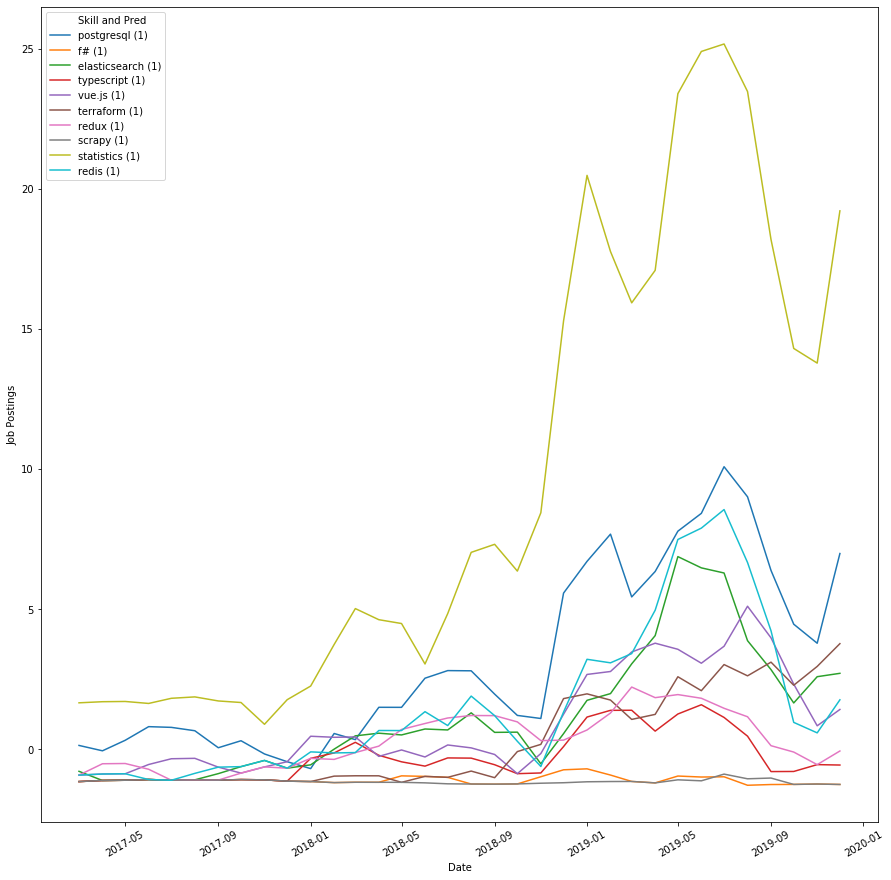

In [377]:
feature_number = 14
n_skills_to_get = 10
preds_to_get = 'pos'
pos_neg_or_both = 'both'

if preds_to_get == 'pos':
    preds_to_look_at = all_preds_x_values.loc[all_preds_x_values.pred == 1]
elif preds_to_get == 'neg':
    preds_to_look_at = all_preds_x_values.loc[all_preds_x_values.pred == 0]
else:
    preds_to_look_at = all_preds_x_values

if pos_neg_or_both == 'pos':
    top_datapoints = (np.argsort(series_to_matrix(preds_to_look_at['tsfresh'])
                             [:, feature_number])[-n_skills_to_get:])[::-1].flatten()
elif pos_neg_or_both == 'neg':
    top_datapoints = (np.argsort(-series_to_matrix(preds_to_look_at['tsfresh'])
                             [:, feature_number])[-n_skills_to_get:])[::-1].flatten()
else:
    top_datapoints = (np.argsort(np.abs(series_to_matrix(preds_to_look_at['tsfresh'])
                             [:, feature_number]))[-10:])[::-1].flatten()
top_skills = preds_to_look_at.iloc[top_datapoints].Skill.values
top_skill_labels = preds_to_look_at.iloc[top_datapoints].pred.values
skill_to_label = {top_skills[i]: top_skill_labels[i] for i in range(len(top_skills))}
multi_skill_df = multiple_skill_pop_profiles(skills_df, top_skills, 'log', time_period=TIME_PERIODS['2017-2020'], 
                          normaliser=log_mean, smooth='movingavg')
multi_skill_df['Skill and Pred'] = multi_skill_df['Skill'].apply(lambda x: 
                                                                 x + ' (' + str(int(skill_to_label[x])) + ')')
ax = plt.figure(num=1, figsize=(15,15))
sns.lineplot(x='Date', y='Job Postings', data=multi_skill_df, hue='Skill and Pred')
# plt.hlines(one_skill_df['Job Postings'].mean(), 
#            TIME_PERIODS['2017-2020'][0], TIME_PERIODS['2017-2020'][1], colors=['blue'], linestyles='dashdot')
plt.xticks(rotation=30)
plt.show()

## Analysing the features of _predicted positives_

In [2211]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [2212]:
all_positive_preds = pd.concat([test_pred_positive_df, train_pred_positive_df]).sort_values('common_index')
all_positive_preds_x_values = pd.concat([sampled_train_x_df, sampled_test_x_df])
all_positive_preds_x_values = all_positive_preds_x_values.loc[all_positive_preds_x_values.common_index.apply(
                    lambda x: x in all_positive_preds.common_index.values)].sort_values('common_index')
all_positive_preds_x_values['tsfresh'] = best_model[1].transform(
                            series_to_matrix(all_positive_preds_x_values['tsfresh'])).tolist()
cluster_model = AgglomerativeClustering(n_clusters=10)
all_positive_preds['cluster'] = \
                cluster_model.fit_predict(series_to_matrix(all_positive_preds_x_values['tsfresh_orig']))
all_positive_preds_x_values['cluster'] = \
                cluster_model.fit_predict(series_to_matrix(all_positive_preds_x_values['tsfresh_orig']))

In [2213]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(all_positive_preds.sort_values('cluster'))

,Skills,row_class,common_key,common_index,pred,cluster
133,keras,1,keras_2017-2020,172,1.0,0
129,junit,0,junit_2017-2019,168,1.0,0
144,matlab,0,matlab_2017-2019,195,1.0,0
54,nginx,0,nginx_2017-2019,219,1.0,0
100,graphql,1,graphql_2017-2020,133,1.0,0
99,graphql,1,graphql_2017-2019,132,1.0,0
79,pytorch,1,pytorch_2017-2020,277,1.0,0
219,selenium,0,selenium_2017-2019,318,1.0,0
63,npm,0,npm_2017-2019,231,1.0,0
261,webpack,1,webpack_2017-2019,372,1.0,0


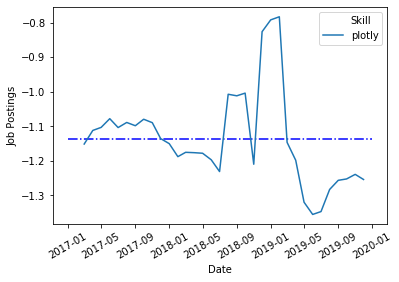

In [2387]:
one_skill_df = investigate_skill_pop_profile(
                    skills_df, 'plotly', 'log', time_period=TIME_PERIODS['2017-2020'], 
                          normaliser=log_mean, smooth='movingavg', ref_for_dates=log_mean)
sns.lineplot(x='Date', y='Job Postings', data=one_skill_df, hue='Skill')
plt.hlines(one_skill_df['Job Postings'].mean(), 
           TIME_PERIODS['2017-2020'][0], TIME_PERIODS['2017-2020'][1], colors=['blue'], linestyles='dashdot')
plt.xticks(rotation=30)
plt.show()

In [2381]:
skills_df.loc[skills_df.Skill == 'plotly']

,Company,Skill,Date,Job Postings Raw,Total,Job Postings
95541,HP,plotly,2018-08-01,1,12,0.083333
95617,HP,plotly,2018-12-01,2,12,0.166667


## Analysing the features of _all predictions_

In [2269]:
cluster_model = AgglomerativeClustering(n_clusters=30, affinity='euclidean', linkage='ward')
# all_preds['cluster'] = \
#                 cluster_model.fit_predict(series_to_matrix(all_preds_x_values['tsfresh_orig']))
all_preds_x_values['cluster'] = \
                cluster_model.fit_predict(series_to_matrix(all_preds_x_values['tsfresh']))
all_preds = pd.merge(all_preds, all_preds_x_values[['common_index', 'cluster']], on='common_index')

In [2270]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(all_preds.sort_values('cluster'))

,Skills,row_class,common_key,common_index,pred,cluster
18,amazon web services,0,amazon web services_2017-2020,19,0.0,0
2,.net,0,.net_2018-2020,2,0.0,0
151,java,0,java_2017-2019,153,0.0,0
331,statistics,1,statistics_2017-2020,337,0.0,1
30,angularjs,0,angularjs_2018-2020,32,0.0,1
26,android,0,android_2017-2020,28,0.0,1
150,ios,0,ios_2018-2020,152,0.0,1
209,mysql,0,mysql_2018-2020,212,0.0,1
65,c,0,c_2017-2020,67,0.0,1
1,.net,0,.net_2017-2020,1,0.0,2


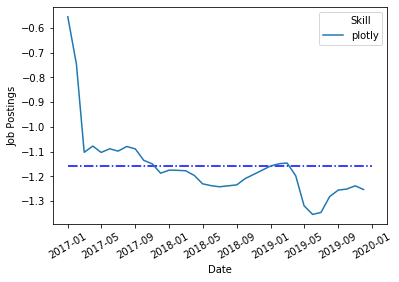

In [2361]:
one_skill_df = investigate_skill_pop_profile(
                    skills_df, 'plotly', 'log', time_period=TIME_PERIODS['2017-2020'], 
                          normaliser=log_mean, smooth='movingavg', ref_for_dates=log_mean)
sns.lineplot(x='Date', y='Job Postings', data=one_skill_df, hue='Skill')
plt.hlines(one_skill_df['Job Postings'].mean(), 
           TIME_PERIODS['2017-2020'][0], TIME_PERIODS['2017-2020'][1], colors=['blue'], linestyles='dashdot')
plt.xticks(rotation=30)
plt.show()

In [1938]:
pca_model.explained_variance_ratio_

array([9.86787204e-01, 1.14444775e-02, 1.31904471e-03, 1.70076801e-04,
       7.54321401e-05, 4.03934916e-05, 3.80759975e-05, 3.23639613e-05,
       2.15228428e-05, 1.93303441e-05, 1.51234155e-05, 1.21229796e-05,
       9.42818457e-06, 4.14741753e-06, 3.10270125e-06, 1.90308474e-06,
       1.10243122e-06, 9.82678737e-07, 8.98957041e-07, 5.33664742e-07,
       3.73012081e-07, 3.45198407e-07, 2.59110826e-07, 2.27414973e-07,
       1.74277863e-07, 1.46367417e-07, 1.27517827e-07, 1.19959353e-07,
       9.73749589e-08, 8.76297360e-08, 7.43582083e-08, 6.47408324e-08,
       5.80123029e-08, 4.93449030e-08, 4.52460970e-08, 4.28976103e-08,
       4.17284361e-08, 3.58224920e-08, 3.25446348e-08, 3.20170743e-08,
       2.73920646e-08, 2.43320928e-08, 2.33415353e-08, 1.95250163e-08,
       1.89631439e-08, 1.71245529e-08, 1.50477835e-08, 1.31926448e-08,
       1.24452870e-08, 1.06951937e-08])

In [1939]:
np.std(best_model[1].transform(series_to_matrix(sampled_train_x_df['tsfresh'])), axis=0)

array([136.87533114,  12.36046489,  45.10035625,   7.89512075,
         2.12867045,   1.24911182,   1.08099128,   1.24414669,
         1.01463692,   1.01518787,   0.93894427,   1.74617354,
         1.13862811,   2.80177972,   1.83070423,   2.63303173,
         1.54514738,   3.6755937 ,   1.98161757,   0.88126224,
         0.94066032,   0.86509481,   1.75315405,   2.04316453,
         1.56557589,   2.0232623 ,   2.03712145,   1.49352655,
         1.56586358,   1.51883801,   1.48825088,   1.16338639,
         1.21213652,   1.16909494,   1.14026302,   0.98217142,
         1.08187682,   1.30172394,   1.17779762,   1.15434135,
         1.07094948,   1.19809129,   1.07929286,   1.36994841,
         1.30893847,   1.29167404,   1.1750216 ,   1.15802016,
         1.21594274,   0.98148544])

In [1940]:
np.median(best_model[1].transform(series_to_matrix(sampled_train_x_df['tsfresh'])), axis=0)

array([-0.33428824, -0.32095273,  0.15840613,  0.09800055, -0.2341233 ,
        0.03594497, -0.13766958, -0.09434257, -0.20324757, -0.02199893,
        0.01652841, -0.02003177, -0.16377505,  0.21733584, -0.16299962,
       -0.03279001,  0.09009381, -0.19693271,  0.00667413, -0.03695995,
       -0.11051083,  0.03196017,  0.02712601, -0.05649428, -0.02927123,
       -0.0940839 ,  0.0578364 ,  0.03833357, -0.06021658, -0.06630603,
       -0.04792829,  0.11092328, -0.05780469,  0.04651904,  0.0104103 ,
       -0.07581921,  0.07886204,  0.02687527, -0.06134974, -0.0431224 ,
        0.06868576, -0.02556506, -0.01843524,  0.07819865, -0.01714409,
        0.07819984,  0.01575813, -0.09416303, -0.02530381, -0.14365259])

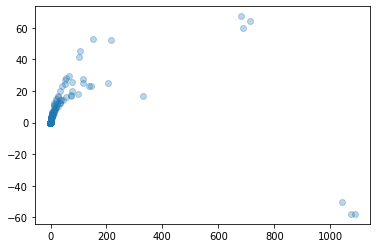

In [1941]:
plt.scatter(best_model[1].transform(series_to_matrix(sampled_train_x_df['tsfresh']))[:,0], 
            best_model[1].transform(series_to_matrix(sampled_train_x_df['tsfresh']))[:,1], alpha=0.3)

## Binpop

### Preprocessing

In [1942]:
# feature_type_to_use = 'linreg_nointercept'
# params_to_use = {feature_type_to_use:{'degree':2}}

params_to_use = {'tsfresh':{}, 'linreg_nointercept':{'degree': 2}}

In [1943]:
# # Run compute_total_poptype_mean with pop_type='bin' (for the normalisation) on original ad df
# bin_mean = compute_total_poptype_mean(skills_df, pop_type='bin')
# # Run compile_all_feature_dfs with pop_type='bin' on skills ad df
# bin_features_df = compile_all_feature_dfs(skills_df, TIME_PERIODS, bin_mean, 
#                                           feature_types=['tsfresh', 'linreg_nointercept'], 
#                                           pop_type='bin', params=params_to_use)
# # # Run skills_to_indices to generate indices.

# # # Run create_train_test_split to create the training and test sets.

# # # Run generate_cv_folds on the training data to get... cv folds.

In [1944]:
# with open('bin_features_df_and_mean.pkl', 'wb') as f:
#     pickle.dump((bin_features_df, bin_mean), f)

In [1945]:
with open('bin_features_df_and_mean.pkl', 'rb') as f:
    bin_features_df, bin_mean = pickle.load(f)

In [1946]:
tsfresh_feature_names = open('../tsfresh_feature_names.txt', 'r').readlines()

In [1947]:
tsfresh_feature_names = [x.strip() for x in tsfresh_feature_names]
tsfresh_feature_names

['abs_energy',
 'absolute_sum_of_changes',
 'agg_autocorrelation__f_agg_"mean"__maxlag_40',
 'agg_autocorrelation__f_agg_"median"__maxlag_40',
 'agg_autocorrelation__f_agg_"var"__maxlag_40',
 'agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"',
 'agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"',
 'agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"',
 'agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"',
 'agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"',
 'agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"',
 'agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"',
 'agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"intercept"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"rvalue"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"slope"',
 'agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"stderr"',
 'agg_linear_trend__f_agg_"mean"__chunk_len_10__att

In [1949]:
bin_features_df, tsfresh_feature_names = \
            clean_nan_features(bin_features_df, colname='tsfresh',
                            feature_names=tsfresh_feature_names)

In [1950]:
df_x_datapoints_with_ground_truth, df_y_all, df_x_all, datapoints_all_indices = \
                        skills_to_indices(bin_features_df, y_reformatted)

     Skill                                            tsfresh  \
0     .net  [1927.4444444444446, 13.999999999999996, -0.08...   
3414  .net  [4830.0, 45.999999999999986, -0.04185645365114...   
4294  .net  [16232.333333333336, 100.66666666666667, -0.27...   
684   .net  [2272.7777777777783, 23.333333333333332, -0.05...   
2445  .net  [13675.111111111111, 78.0, -0.2343684240755835...   

                                     linreg_nointercept  Job Postings Raw  \
0     [-0.37039963205931054, 0.017174514311322758, 1...               285   
3414  [0.2940865382165749, -0.00999468540069434, 1.3...               642   
4294  [-0.2961716169266051, 0.024758863063801345, 2....              1307   
684   [-0.6775385295402145, 0.03635039218688915, 1.1...               357   
2445  [1.5140547864187057, -0.018861198357340174, 1....              1022   

     time_period      common_key  
0      2017-2018  .net_2017-2018  
3414   2017-2019  .net_2017-2019  
4294   2017-2020  .net_2017-2020  
684   

In [1951]:
df_x_datapoints_with_ground_truth.tsfresh.values[0].size

331

In [1993]:
sampled_train_x_df, sampled_test_x_df, sampled_train_y_df, sampled_test_y_df = \
    create_train_test_split(df_x_datapoints_with_ground_truth, df_y_all, 
                            test_proportion=0.3, class_balanced=True, random_state=5)

sampled_train_x_df, sampled_test_x_df, pca_model, pre_normaliser, throwaway = \
    pre_normalise_and_pca(sampled_train_x_df, sampled_test_x_df, 
                         n_features=50, pre_normaliser=StandardScaler(with_std=False), post_normaliser=None)

Let's see how many members each class has.

In [1994]:
sampled_train_y_df[['row_class', 'common_key']].groupby('row_class').count()

,common_key
row_class,
0,216
1,54


In [1995]:
sampled_test_y_df[['row_class', 'common_key']].groupby('row_class').count()

,common_key
row_class,
0,91
1,23


In [1996]:
sampled_train_y_df.shape

(270, 4)

In [1997]:
resulting_dfs = generate_cv_folds(sampled_train_x_df, sampled_train_y_df, stratified=False)

### Computation (training and validation)

In [1998]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [1999]:
feature_type_to_use = 'tsfresh'
# feature_type_to_use = 'linreg_nointercept'

In [2000]:
# Run cross_validate_with_quantile with the appropriate feature column name. 
# Set C_LIST and QUANTILES through utilities/params.py
# normaliser = RobustScaler(with_centering=False, with_scaling=True, quantile_range=(30, 70))
# normaliser = RobustScaler(with_scaling=False)
# normaliser = None
# normaliser = StandardScaler(with_std=False)
normaliser = StandardScaler(with_std=True)
best_model, best_c, best_q, best_score = \
    cross_validate_with_quantile(resulting_dfs, log_features_df, normaliser=normaliser, 
             features_col=feature_type_to_use, c_list= np.logspace(start=-8, stop=7, num=16, base=10), 
                                 eval_type='prec', quantiles=np.linspace(0.80, 0.90, num=3), model_to_use='logreg')

tsfresh
QUANTILE: 0.8

-----------


C: 1e-08

-----------



[0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
31
31
54

[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0]
31
31
54

[0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
34
34
53

[1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1]
30
30
53

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.45487179487179497

**********


C: 1e-07

-----------



[0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
31
31
54

[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0]
31
31
54

[0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
34
34
53

[1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1]
30
30
53

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.45487179487179497

**********


C: 1e-06

-----------



[0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.45487179487179497

**********


C: 1e-05

-----------



[0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
31
31
54

[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0]
31
31
54

[0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
34
34
53

[1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1]
30
30
53

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.45487179487179497

**********


C: 0.0001

-----------



[0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
31
31
54

[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0]
31
31
54

[0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
34
34
53

[1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1]
30
30
53

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.454871794871794

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
31
31
54

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0]
31
31
54

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34
34
53

[1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1]
30
30
53

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.505

**********


C: 0.1

-----------



[0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
31
31
54

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0]
31
31
54

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34
34
53

[1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0]
30
30
53

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.4883333333333333

**********


C: 1.0

-----------



[0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
31
31
54

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.30166666666666664

**********


C: 10.0

-----------



[0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1]
31
31
54

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31
31
54

[0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34
34
53

[1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
30
30
53

[1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.298974358974359

**********


C: 100.0

-----------



[0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1]
31
31
54

[1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
31
31
54

[0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]
34
34
53

[1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
30
30
53

[1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.3113553113553113

*

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
31
31
54

[0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0]
34
34
53

[1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
30
30
53

[1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0]
33
33
53
Avg score: 0.30897435897435893

**********


C: 10000.0

-----------



[0 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1]
31
31
54

[1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
31
31
54

[0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]
34
34
53

[1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0]
30
30
53

[1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0]
33
33
53
Avg score: 0.3383333333333333

**********


C: 100000.0

-----------





/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1]
31
31
54

[1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
31
31
54

[0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0]
34
34
53

[1 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0]
30
30
53



/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0]
33
33
53
Avg score: 0.3476923076923077

**********


C: 1000000.0

-----------



[0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1]
31
31
54

[1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1]
31
31
54



/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0]
34
34
53

[1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0]
30
30
53

[1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1]
33
33
53
Avg score: 0.33277777777777773

**********


C: 10000000.0

-----------





/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1]
31
31
54

[1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1]
31
31
54



/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureW

[0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0]
34
34
53

[1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0]
30
30
53

[1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1]
33
33
53
Avg score: 0.33277777777777773

**********



QUANTILE: 0.8500000000000001

-----------


C: 1e-08

-----------



[0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
37
37
54

[0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0
 0]
38
38
54

[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0]
38
38
53

[1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1]
36
36
53

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1
 0 0 0]
40
40
53
Avg score: 0.49428571428571433

**********


C: 1e-07

-----------



[0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
37
37
54

[0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1]
36
36
53

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1
 0 0 0]
40
40
53
Avg score: 0.49428571428571433

**********


C: 1e-05

-----------



[0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
37
37
54

[0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0
 0]
38
38
54

[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0]
38
38
53

[1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1]
36
36
53

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1
 0 0 0]
40
40
53
Avg score: 0.49428571428571433

**********


C: 0.0001

-----------



[0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
37
37
54

[0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0
 0]
38
38
54

[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1
 0 0 0]
40
40
53
Avg score: 0.5117460317460317

**********


C: 0.01

-----------



[0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
37
37
54

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0
 0]
38
38
54

[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
38
38
53

[1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1]
36
36
53

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1
 0 0 0]
40
40
53
Avg score: 0.5384559884559883

**********


C: 0.1

-----------



[0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
37
37
54

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0
 0]
38
38
54

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
38
38
53

[1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0
 0 0 0]
40
40
53
Avg score: 0.30301587301587307

**********


C: 10.0

-----------



[0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0]
37
37
54

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0]
38
38
54

[0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0]
38
38
53

[1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0]
36
36
53

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0
 0 0 0]
40
40
53
Avg score: 0.23857142857142857

**********


C: 100.0

-----------



[0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0]
37
37
54

[1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0]
38
38
54

[0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0]
38
38
53

[1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0]
38
38
54

[0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 0]
38
38
53

[1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0]
36
36
53

[1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0
 0 0 0]
40
40
53
Avg score: 0.28816183816183816

**********


C: 10000.0

-----------



[0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0]
37
37
54

[1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0]
38
38
54

[0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 0]
38
38
53

[1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0]
36
36
53

[1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0
 0 0 0]
40
40
53
Avg score: 0.2798913504795858

**********


C: 100000.0

-----------





/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0]
37
37
54

[1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0]
38
38
54

[0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 0]
38
38
53

[1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0]
36
36
53

[1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0
 0 0 0]
40
40
53
Avg score: 0.2835678210678211

**********


C: 1000000.0

-----------



[0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0]
37
37
54

[1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0]
38
38
54

[0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 0]
38
38
53

[1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0]
36
36
53



/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0
 0 0 0]
40
40
53
Avg score: 0.2835678210678211

**********


C: 10000000.0

-----------



[0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0]
37
37
54

[1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0]
38
38
54

[0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 0]
38
38
53

[1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0]
36
36
53

[1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0
 0 0 0]
40
40
53
Avg score: 0.2835678210678211

**********



QUANTILE: 0.9

-----------


C: 1e-08

-----------



[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0]
43
43
54

[0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 1 0 0 0]
45
45
54

[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0]
42
42


/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur


[0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1
 0 0 0 1 0 0]
43
43
53

[1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.4504761904761905

**********


C: 1e-07

-----------



[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0]
43
43
54

[0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 1 0 0 0]
45
45
54

[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0]
42
42
53

[0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1
 0 0 0 1 0 0]
43
43
53

[1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.4504761904761905

**********


C: 1e-06

-----------



[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0]
43
43
54

[0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0]
42
42
53

[0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1
 0 0 0 1 0 0]
43
43
53

[1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.42666666666666664

**********


C: 0.0001

-----------



[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0]
43
43
54

[0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 1 0 0 0]
45
45
54

[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0]
42
42
53

[0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1
 0 0 0 1 0 0]
43
43
53

[1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.42666666666666664

**********


C: 0.001

-----------



[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 1 0 0 0]
45
45
54

[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0]
42
42
53

[0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1
 0 0 0 1 0 0]
43
43
53

[1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.44000000000000006

**********


C: 0.1

-----------



[0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0]
43
43
54

[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 1 0 0 0]
45
45
54

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0]
42
42
53

[0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1
 0 0 0 1 0 0]
43
43
53

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.36337662337662335


/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur


[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0]
45
45
54

[0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0]
42
42
53

[0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 1 0 0 0]
43
43
53

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.2832539682539682

**********


C: 100.0

-----------



[0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1
 0 0 0 0 0 0]
43
43
54

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0]
45
45
54

[0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1
 0 0 0 0 0]
42
42
53

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 1 0 0 0]
43
43
53

[1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.3280952380952381

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0]
42
42
53

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 1 0 0 0]
43
43
53

[1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.3025

**********


C: 10000.0

-----------



[0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 1 0 0]
43
43
54

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0]
45
45
54

[0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0]
42
42
53

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 0]
43
43
53

[1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.33345238095238094

**********


C: 100000.0

-----------



[0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0]
42
42
53

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 0]
43
43
53

[1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.33345238095238094

**********


C: 1000000.0

-----------



[0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 1 0 0]
43
43
54

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0]
45
45
54

[0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0]
42
42
53

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 0]
43
43
53

[1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0]
45
45
53
Avg score: 0.33345238095238094

**********


C: 10000000.0

-----------



[0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 0 0 

/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ramtinyazdanian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

In [2001]:
print(best_model, best_c, best_q, best_score)

(LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), StandardScaler(copy=True, with_mean=True, with_std=True)) 0.01 0.8500000000000001 0.5384559884559883


### Evaluation (test and manual investigation)

Test set:

In [2002]:
# Run predict_and_evaluate_dfs and get_error_rate_for_each_period
predict_and_evaluate_dfs(best_model[0], sampled_test_x_df, sampled_test_y_df, 
                         rawpop_upper_bounds=compute_time_period_rawpop_quantile_thresholds(bin_features_df, best_q),
                         features_col=feature_type_to_use, 
                         normaliser=best_model[1], eval_type='prfs', return_modified_df=True)

[1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0]
87
87
114


(array([0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 (0.5333333333333333, 0.34782608695652173, 0.4210526315789474, None),
             Skills  row_class               common_key  common_index  pred
 1         anaconda          1       anaconda_2017-2020            22   1.0
 2         anaconda          1       anaconda_2018-2020            23   1.0
 4     apache spark          0   apache spark_2017-2020            46   1.0
 27              f#          1             f#_2017-2019           114   1.0
 33          gradle          0      

Let's compare that to some random baselines:

In [4471]:
evaluate_results(np.array([1]*sampled_test_y_df.shape[0]), sampled_test_y_df[TRUTH_COL].values, type='prfs')

(0.13978494623655913, 1.0, 0.24528301886792453, None)

In [4472]:
evaluate_results((np.random.rand(sampled_test_y_df.shape[0])<(155/396)).astype(int), 
                 sampled_test_y_df[TRUTH_COL].values, type='prfs')

(0.21875, 0.5384615384615384, 0.3111111111111111, None)

So our method is essentially beaten by both a 1-only _and_ a random classifier. So much for classification.

Training set:

In [4473]:
# Run predict_and_evaluate_dfs and get_error_rate_for_each_period
predict_and_evaluate_dfs(best_model[0], sampled_train_x_df, sampled_train_y_df, 
                         rawpop_upper_bounds=compute_time_period_rawpop_quantile_thresholds(bin_features_df, best_q),
                        normaliser=best_model[1], eval_type='prfs', features_col=feature_type_to_use, 
                         return_modified_df=True)

[1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 0]
153
153
222


(array([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.])

And now interpreting the best model:

In [4474]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(interpret_model(best_model[0], tsfresh_feature_names, pca_model=pca_model, n_features=None))
# interpret_model(best_model[0], FEATURE_NAMES[feature_type_to_use])

,Name,Score,Features
15,14,10.978037,"[(fft_coefficient__coeff_1__attr_""imag"", 0.3417088728990879), (fft_coefficient__coeff_1__attr_""abs"", 0.3154802422652693), (fft_coefficient__coeff_2__attr_""abs"", 0.16887031647262132), (fft_coefficient__coeff_2__attr_""imag"", 0.162310845515175), (time_reversal_asymmetry_statistic__lag_1, 0.12711986206269707), (absolute_sum_of_changes, 0.1205761992828397), (sum_of_reoccurring_data_points, 0.11162182742828161), (c3__lag_1, 0.10806710978963462), (sum_values, 0.09362889789756723), (fft_coefficient__coeff_0__attr_""real"", 0.09362889789756688), (fft_coefficient__coeff_0__attr_""abs"", 0.09362889789756688), (fft_coefficient__coeff_4__attr_""angle"", 0.09198528342597707), (c3__lag_3, 0.0813852181161953), (time_reversal_asymmetry_statistic__lag_3, 0.07623644465156681), (variance, 0.07121456049667974), (length, 0.060625503004213044), (range_count__max_1000000000000.0__min_0, 0.060625503004213044), (fft_coefficient__coeff_1__attr_""real"", 0.05936940571148663), (fft_coefficient__coeff_5__attr_""abs"", 0.052117981849084304), (spkt_welch_density__coeff_5, 0.051869238669974255)]"
13,12,9.947596,"[(time_reversal_asymmetry_statistic__lag_1, 0.5039328427899336), (time_reversal_asymmetry_statistic__lag_3, 0.1959254345753487), (fft_coefficient__coeff_4__attr_""angle"", 0.14213737890064382), (fft_coefficient__coeff_2__attr_""angle"", 0.09611026511175158), (fft_coefficient__coeff_1__attr_""angle"", 0.08692202927123095), (change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.0, 0.07377922906903349), (fft_coefficient__coeff_4__attr_""real"", 0.06474080525875628), (fft_coefficient__coeff_3__attr_""angle"", 0.0600663503722392), (fft_coefficient__coeff_2__attr_""real"", 0.05500469695917194), (absolute_sum_of_changes, 0.05423696295370296), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_10, 0.054050269652135406), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_10, 0.0526772972409145), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_10, 0.050274485684476275), (change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.8, 0.04964706326585264), (sum_of_reoccurring_data_points, 0.04776971714171263), (change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.0, 0.0471483418059307), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_10, 0.04681447520080263), (agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""intercept"", 0.04679706398855093), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_10, 0.04238304676000759), (fft_coefficient__coeff_4__attr_""imag"", 0.03936783455667978)]"
0,s_min,9.326056,None
2,1,8.825924,"[(c3__lag_3, 0.2295509581971504), (c3__lag_2, 0.19236347370964585), (c3__lag_1, 0.11968169510260863), (time_reversal_asymmetry_statistic__lag_3, 0.09085392794602962), (time_reversal_asymmetry_statistic__lag_2, 0.012917369894046002), (fft_coefficient__coeff_5__attr_""angle"", 0.008161485778600343), (fft_coefficient__coeff_2__attr_""real"", 0.004367333202653835), (fft_coefficient__coeff_4__attr_""angle"", 0.0043629585918629615), (fft_coefficient__coeff_4__attr_""real"", 0.0016285161351247115), (fft_coefficient__coeff_3__attr_""real"", 0.001573126857150516), (range_count__max_1__min_-1, 0.0014500230650530057), (value_count__value_0, 0.0013331958836176772), (fft_coefficient__coeff_4__attr_""imag"", 0.0011354860869878115), (number_crossing_m__m_0, 0.0006004532202305868), (number_crossing_m__m_1, 0.0004082505438782305), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_2, 0.0003809311098909882), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_2, 0.0003456384118214387), (fft_coefficient__coeff_5__attr_""imag"", 0.00032238246220099337), (cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_5, 0.00030781517876910197), (cid_ce__normalize_True, 0.00025283825230024853)]"
9,8,7.837223,"[(fft_coefficient__coeff_4__attr_""angle"", 0.4994790675636776), (fft_coefficient__coeff_3__attr_""angle"", 0.3677848135496324), (fft_coefficient__coeff_1__attr_""angle"", 0.31334867273883743), (fft_c

In [4475]:
np.std(best_model[1].transform(series_to_matrix(sampled_train_x_df['tsfresh'])), axis=0)

array([298.74249568,  15.7255104 , 198.74356898,  20.82759404,
         2.3714626 ,   1.14419677,   0.87068659,   0.94562858,
         1.19635238,   1.63790285,   1.31526981,   2.1072809 ,
         3.17733648,   2.14972006,   1.53623899,   2.49647686,
         1.73779029,   1.79483458,   1.50717783,   1.42638425,
         1.35534716,   1.2437645 ,   1.27644576,   1.55639362,
         1.80693991,   1.5325736 ,   1.4842346 ,   1.15346003,
         1.97300883,   1.62663244])

## The winning method

We now have a winning method + hyperparameters + weights from the previous step, and the best model is trained on the entire training set. Now, we use this model to compute the emerging skills for every period.

### Looking at feature importance

### Comparing emerging skill sets from different years

# Creating sets of firms

## HITS on emerging skill sets

## POP based on ad counts

## REV based on revenue (different groupings)

## EMC based on employee count (different groupings)